### Figure 4 
- Sliding template during sleep deprivation
- Correlation across time window

### load data

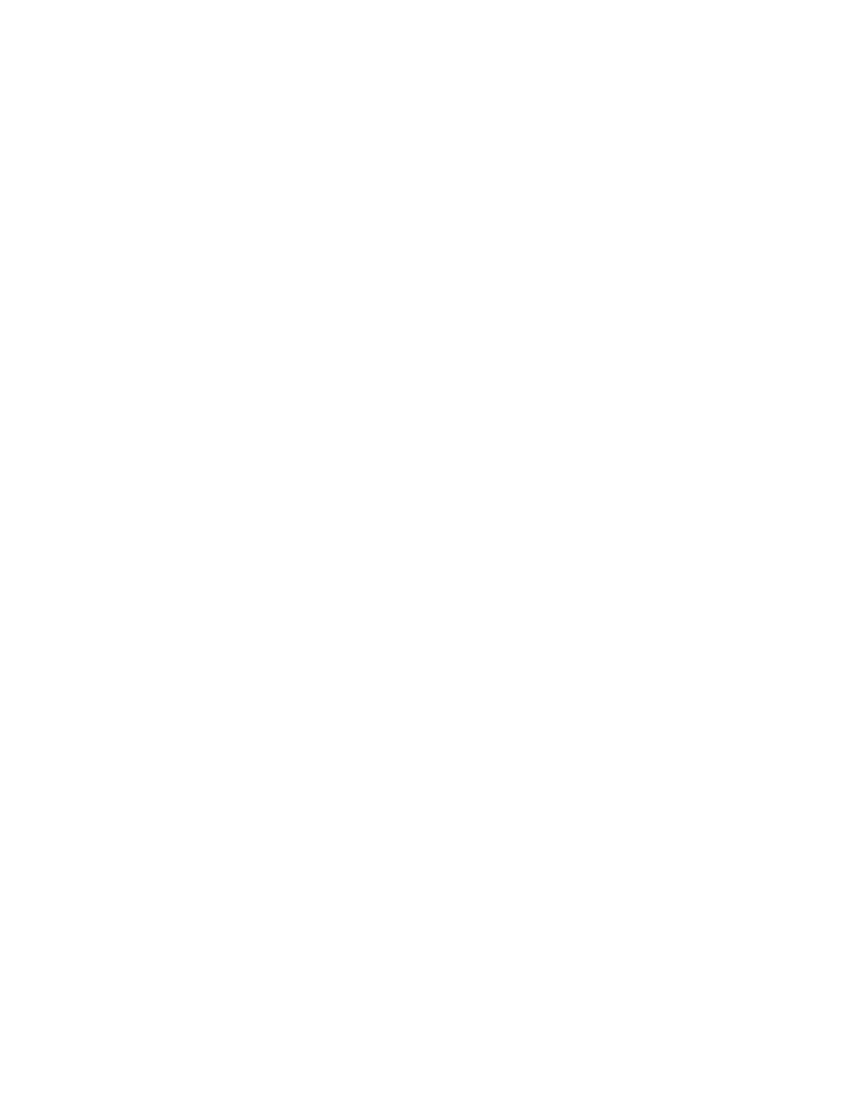

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats

group = ['nsd','sd']
grpdata = subjects.GroupData()
pf_norm_tuning = grpdata.pf_norm_tuning

# post replay score
post_df = grpdata.replay_post_score
# post_df = post_df[np.abs(post_df['velocity'])>100]
post_df['weighted_corr'] = post_df['weighted_corr'].abs()
colors_post = subjects.colors_sd(1)

# re-maze stuff
re_maze_df = grpdata.replay_re_maze_score
re_maze_pos_df = grpdata.replay_re_maze_position_distribution
colors_re_maze = subjects.colors_sd(1)

# position distribution in events
pos_dist_df = grpdata.replay_pos_distribution

fig = Fig(grid=(5, 6), hspace=0.45, wspace=0.5)
filename = subjects.figpath_sd / 'figure4'
caption = 'Place cells: \n(A) Place fields recorded during NSD and SD sessions.'

### pf tuning

In [2]:
from scipy.ndimage import gaussian_filter1d
pf_cmaps = ['Blues','Blues']
for i, grp in enumerate(group):
    df = pf_norm_tuning[pf_norm_tuning['grp']==grp].drop(columns='grp')
    tunings = df.to_numpy()
    x = df.columns.values.astype('float')
    y = np.arange(tunings.shape[0])

    sort_ind = np.argsort(np.argmax(tunings,axis=1))
    tunings = gaussian_filter1d(tunings[sort_ind,:],sigma=0.7,axis=1)


    ax = fig.subplot(fig.gs[:2,i])
    ax.pcolormesh(x,y,tunings,cmap=pf_cmaps[i],rasterized=True)
    ax.set_title(grp.upper())
    ax.set_xticks([0,1])
    ax.set_xlabel('Position')
    if i==0:
        ax.set_ylabel('Neurons')
        fig.panel_label(ax,'A')


### post score

In [3]:
ax = fig.subplot(fig.gs[2:5])
g = sns.violinplot(
    data=post_df,
    x="epoch",
    y="score",
    hue="grp",
    split=True,
    inner=None,
    scale="width",
    palette=colors_post,
    linewidth=0.8,
    # showmedians=True,
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('Zt time (h)')
fig.panel_label(ax,'B')
fig.legend(ax,['NSD','SD'],colors_post)

### post weighted correlation

In [4]:
ax = fig.subplot(fig.gs[3,2:5])
g = sns.violinplot(
    data=post_df,
    x="epoch",
    y="weighted_corr",
    hue="grp",
    split=True,
    inner=None,
    scale="width",
    palette=colors_post,
    linewidth=0.8,
    # showmedians=True,
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('Zt time (h)')
fig.panel_label(ax,'B')
fig.legend(ax,['NSD','SD'],colors_post)

### re-maze score

In [5]:
ax = fig.subplot(fig.gs[5])
g = sns.violinplot(
    data=re_maze_df,
    x="epoch",
    y="score",
    hue="grp",
    split=True,
    inner=None,
    scale="width",
    palette=colors_re_maze,
    linewidth=0.8,
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('')
fig.panel_label(ax,'E')
fig.legend(ax,['NSD','SD'],colors_re_maze)

### post velocity
- we decided to not use this plot, as it didn't add anything meaningful

### post jump distance

In [6]:
ax = fig.subplot(fig.gs[1,2:5])
g = sns.boxplot(
    data=post_df,
    x="epoch",
    y="jump_distance",
    hue="grp",
    width=0.7,
    # split=True,
    # inner=None,
    # scale="width",
    palette=colors_re_maze,
    # linewidth=0.8,
    showfliers=False,
    # cut=0,
    medianprops=dict(color='w',lw=1.5),
    showcaps=False,
    boxprops=dict(edgecolor='none'),
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('')
fig.panel_label(ax,'C')
fig.legend(ax,['NSD','SD'],colors_re_maze)
# sns.despine(ax=ax,offset=True,trim=True)

### re-maze jump distance

In [7]:
ax = fig.subplot(fig.gs[1,5])
g = sns.boxplot(
    data=re_maze_df,
    x="epoch",
    y="jump_distance",
    hue="grp",
    width=0.55,
    # split=True,
    # inner=None,
    # scale="width",
    palette=colors_re_maze,
    # linewidth=0.8,
    showfliers=False,
    # cut=0,
    medianprops=dict(color='w',lw=1.5),
    showcaps=False,
    boxprops=dict(edgecolor='none'),
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('')
ax.set_ylabel('')
fig.panel_label(ax,'E')
fig.legend(ax,['NSD','SD'],colors_re_maze)

### position distribution in events

In [8]:
from neuropy.plotting.dataviz import lineplot
ax = fig.subplot(fig.gs[2,2:5])
lineplot(
    data=pos_dist_df,
    x="bins",
    y="mean_pos",
    hue="grp",
    palette=colors_post,
    # ec=None,
    # linewidth=0.8,
    # ci='sd',
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('Normalized position')
ax.set_ylabel('Mean prob.')
fig.panel_label(ax,'C')
fig.legend(ax,['NSD','SD'],colors_re_maze)

### re-maze position probability in events

In [9]:
from neuropy.plotting.figure import lineplot
ax = fig.subplot(fig.gs[2,5])
lineplot(
    data=re_maze_pos_df,
    x="bins",
    y="mean_pos",
    hue="grp",
    palette=colors_post,
    # ec=None,
    # linewidth=0.8,
    # ci='sd',
    ax=ax,
)

ax.legend([],frameon=False)
ax.set_xlabel('Normalized position')
ax.set_ylabel('Mean prob.')
fig.panel_label(ax,'C')
fig.legend(ax,['NSD','SD'],colors_re_maze)

ImportError: cannot import name 'lineplot' from 'neuropy.plotting.figure' (/home/bapung/Documents/Codes/NeuroPy/neuropy/plotting/figure.py)

### saving

In [ ]:
# fig.savefig(filename,caption=caption)